# Analysis of Guatemala's 2016 math performance results by school

Annually, the Ministry of Education of Guatemala (MINEDUC) evaluates the academic performance of Senior highschool students. The evaluation is focused in two areas: reading comprehension and math skills. The evaluation is mandatory for all the senior students across the country.

Results tend to be specially low in the math. Based on [recently published results](http://www.mineduc.gob.gt/digeduca/documents/investigaciones/2016/Ense%C3%B1ando_mate.pdf), about 9% of the population reach the minimun required level according to the National Curriculum (CNB).

This is a step-by-step analysis of the 2016 results.

[The dataset](http://www.mineduc.gob.gt/digeduca/apps/Bases_de_Datos_Evaluaciones/navegador/2016/documents/GRADUANDOS%202016.xlsx) contains almost 150k test records. More data about every student is also recorded as part of a survey taken alongside the test; so it could be helpful in the future.

The results are measured by two variables:

- `performance_level [1, 4]`
- `achievement_level [0-1]`, where `achievement_level = 0` for `performance_level = 1, 2` and `achievement_level = 1` for `performance_level = 3, 4`.

In [19]:
# Import libraries for exploratory analysis
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

In [2]:
df = pd.read_csv('gr2016.csv')
print('# of columns: {}'.format(df.shape[1]))
print('# of records: {}'.format(df.shape[0]))

# of columns: 108
# of records: 149815


## Assessing performance by school

In later years, some schools have used the results to brag about and advertise their performance as "top 1%" or "top 5%". Given that the base achievement record is only about 9%, we're trying to know how good the perfomance should be in order to be "Top 5%", based on the `achievement_level`.

Let's begin by grouping all the students by school. In this step, our goal is to have a data frame of schools with the amount of students that have 0 or 1 in the `achievement_level` variable. The schools will be identified by the unique code from the MINEDUC. In theory, every school should appear twice, with the total of people with `achievement_level=0` and `achievement_level=1`. In practice, there'll be some schools with either `0` or `1` missing.

In [3]:
# Make groups of records by school's code and approved/reproved ammounts
grupos = df.groupby(['Cod_Estable', 'Logro_Mate'])
# A new dataframe counting how many tuples each group has
convertido = pd.DataFrame({'total': grupos.size()}).reset_index()
convertido.head()

,Cod_Estable,Logro_Mate,total
0,00-01-0158-46,0,20
1,00-01-0173-46,0,75
2,00-01-0173-46,1,5
3,00-01-0174-46,0,181
4,00-01-0174-46,1,10


Now we'll create a new data frame where every record is a school with the ammount of students approving, reproving and the percentage of `achievement_level=1`.

In [4]:
# Create a pivot table grouping each repeter value in the 'Cod_Estable' column
df_final = convertido.pivot(index='Cod_Estable', columns='Logro_Mate', values='total').reset_index()
# Fill NaN values with 0 (for those records with no approved/reproved value)
df_final.fillna(value=0, inplace=True)
# Renaming the columns
df_final.columns = ['udi', 'pierde', 'gana']
# Compute the percentaje of approved students by school
df_final['porcentaje'] = df_final['gana'] / (df_final['gana'] + df_final['pierde']) * 100
df_final.head()

,udi,pierde,gana,porcentaje
0,00-01-0158-46,20.0,0.0,0.000000
1,00-01-0173-46,75.0,5.0,6.250000
2,00-01-0174-46,181.0,10.0,5.235602
3,00-01-0176-46,104.0,41.0,28.275862
4,00-01-0178-46,24.0,1.0,4.000000


### Exploratory analysis
Let's make a simple histogram of the distributions of schools by `percentage`.

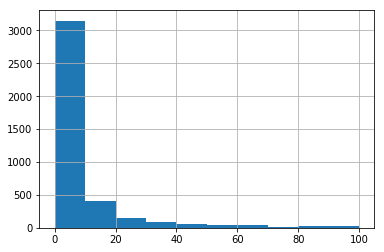

In [5]:
# Simple 
df_final['porcentaje'].hist()
plt.show()

As expected, most of the schools are between the first decile od the distribution. But just to have a clearer vision, let's see how it looks with a percentile distribution.

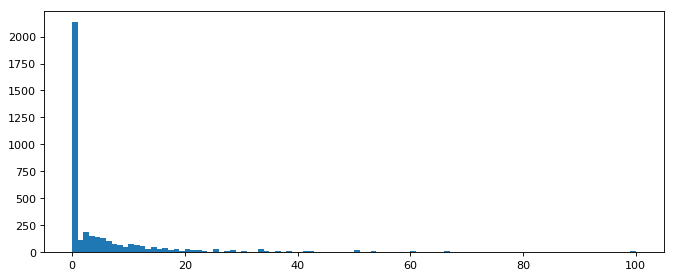

In [6]:
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
# Modifiy the histogram to display 100 bins (aka percentiles)
plt.hist(df_final['porcentaje'], bins=100)
plt.show()

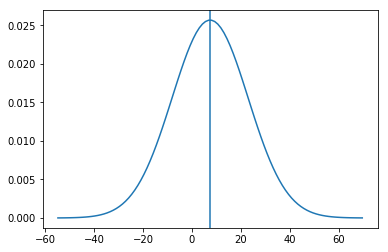

In [25]:
mu = np.mean(df_final['porcentaje'])
variance = np.var(df_final['porcentaje'])
sigma = np.sqrt(variance)

# Plot the normal distribution
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))

# Plot the mean
plt.axvline(x=mu)
plt.show()

Now, let's dive into the actual purpose of this section: finding the threshold of how high the percentage of approved students needs to be in order to achieve the "X top".

In [10]:
# Define the function that'll compute the threshold
# Inputs will be the data frame and the expected percentage
# Outpus will be:
# - thresh: how many schools are located in that "top X%"
# - percentage: the percentage needed in order to be in that group
def encontrar_limite(df_input, porcentaje=50):
    int_df = df_input.sort_values('porcentaje')
    thresh = len(int_df[:int(len(int_df) / (100 / porcentaje))])
    return thresh, int_df.tail(thresh).iloc[0]['porcentaje']

# let's find out how many
schools, percentage = encontrar_limite(df_final, 5)
print('Schools in that group: {}'.format(schools))
print('Percentage of approved students: {}'.format(percentage))

Schools in that group: 199
Percentage of approved students: 40.0


Another interesting experiment is trying to find in which "Top X%" a school is.

In [11]:
# This function will locate the school in the dataset
def encontrar_pos(df_input, udi):
    int_df = df_input.sort_values('porcentaje')
    int_df.reset_index(inplace=True)
    return 1 - int_df[int_df['udi'] == udi].index.tolist()[0] / len(int_df)

top_percentage = encontrar_pos(df_final, '04-01-2870-46')
print('The school is in the {} top percent'.format(round(top_percentage * 100, 2)))

The school is in the 4.13 top percent


In [135]:
por_grupos = df_final.groupby('porcentaje')
len(por_grupos.groups)

672